# Kobe Shots - Show Me Your Best Model

The following notebook presents a thought process of creating and debugging ML algorithm for predicting whether a shot is successfull or missed (binary classification problem).

## 1. Preparation

### Load libraries
Load all required libraries

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load dataset
Let's read the data from CSV file, explicity set an index and convert some columns to `category` type (for better summarization)

In [2]:
data = pd.read_csv('../input/data.csv')

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

Quick look:

In [3]:
data.head(2)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


In [4]:
data.dtypes

action_type             object
combined_shot_type    category
game_event_id         category
game_id               category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
team_id               category
team_name               object
game_date               object
matchup                 object
opponent                object
dtype: object

## 2. Summarize data

### Descriptive statistics
The inital dimension of the dataset:

In [5]:
data.shape

(30697, 24)

Let's take a brief look at all numerical columns statistcs:

In [6]:
data.describe(include=['number'])

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


And for categorical columns:

In [7]:
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,7,2,20,2.0,2,6,7,5,1,1,1559,74,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,132,50,8296,26198,2318,14232.0,24271,13455,12625,9398,30697,30697,50,1020,1978


### Data Visualization 
See target class distribution

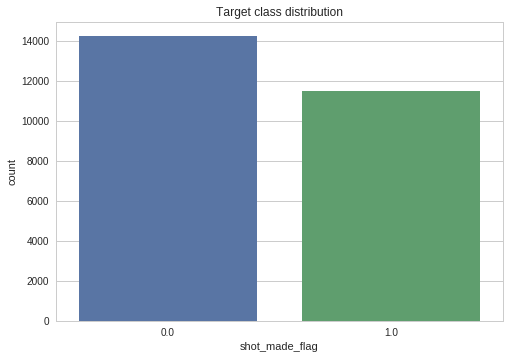

In [8]:
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

At first we can see that the target variable is distributed quite equally. We won't perform any actions to deal with imbalanced dataset.

Data will be presented using boxplot (described in the following image)

![boxplot](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/images/schematic.png)

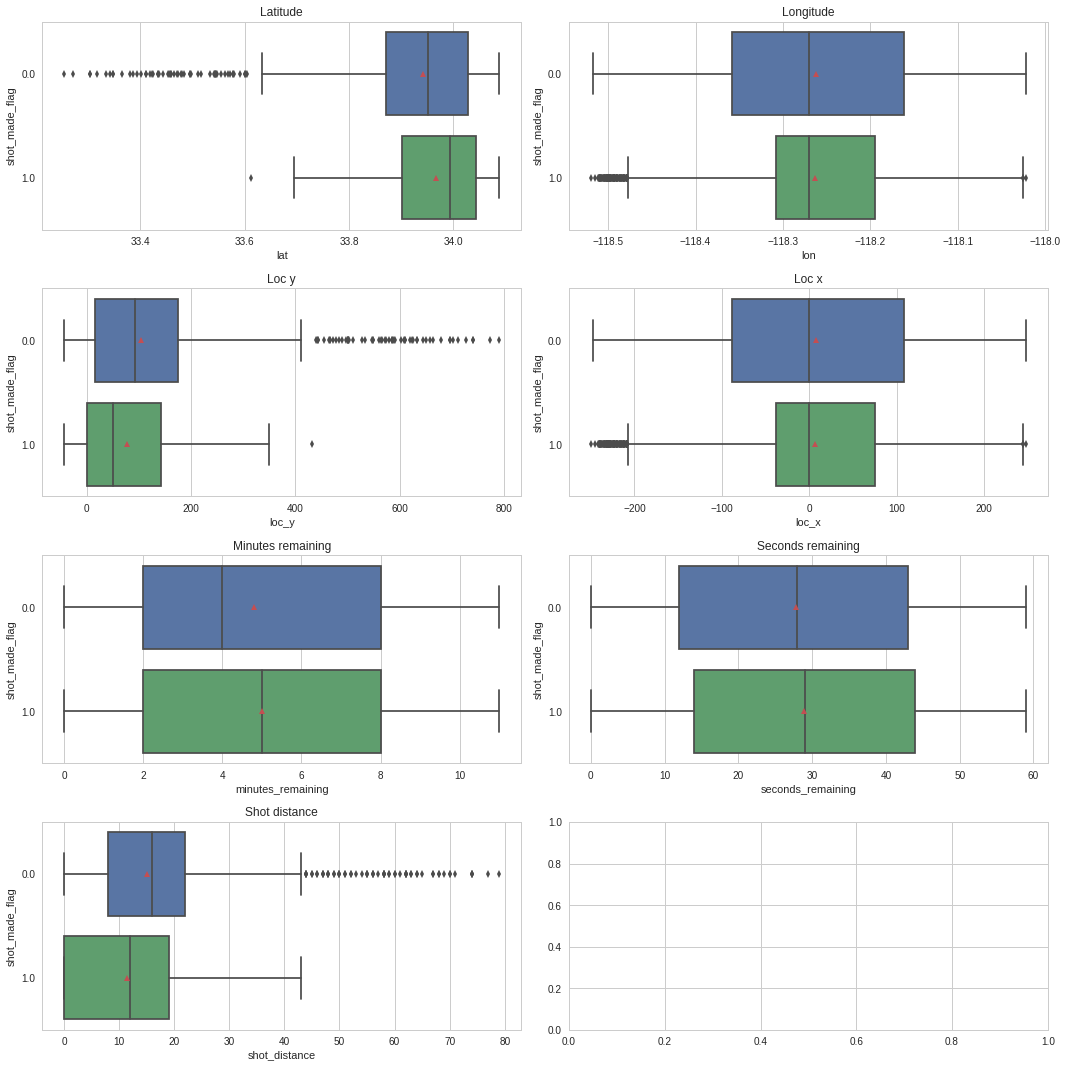

In [9]:
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0])
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0])
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1])
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0])
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1])
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0])

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes remaining')
axarr[2, 1].set_title('Seconds remaining')
axarr[3, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

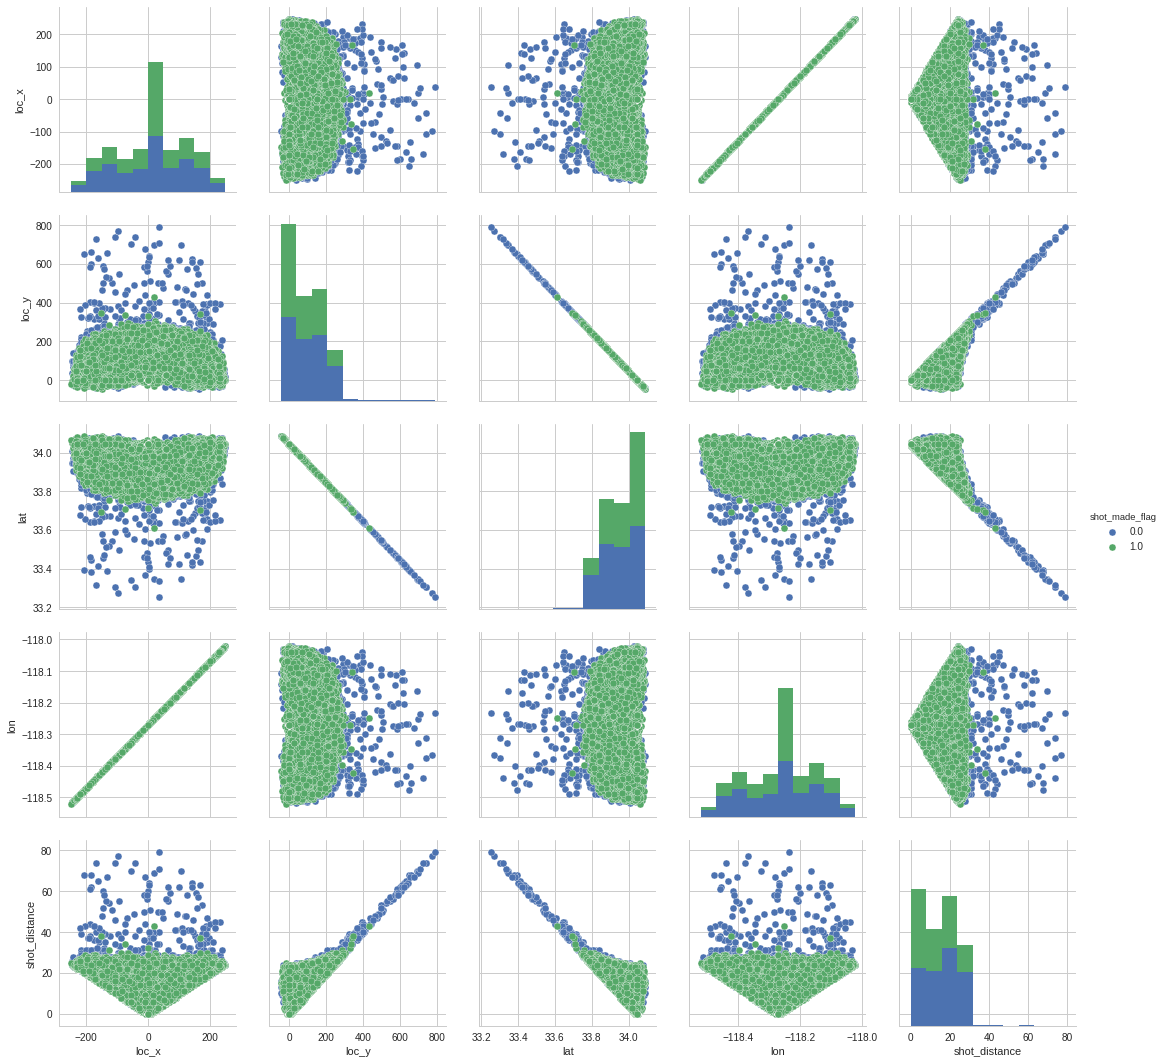

In [10]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3)
plt.show()

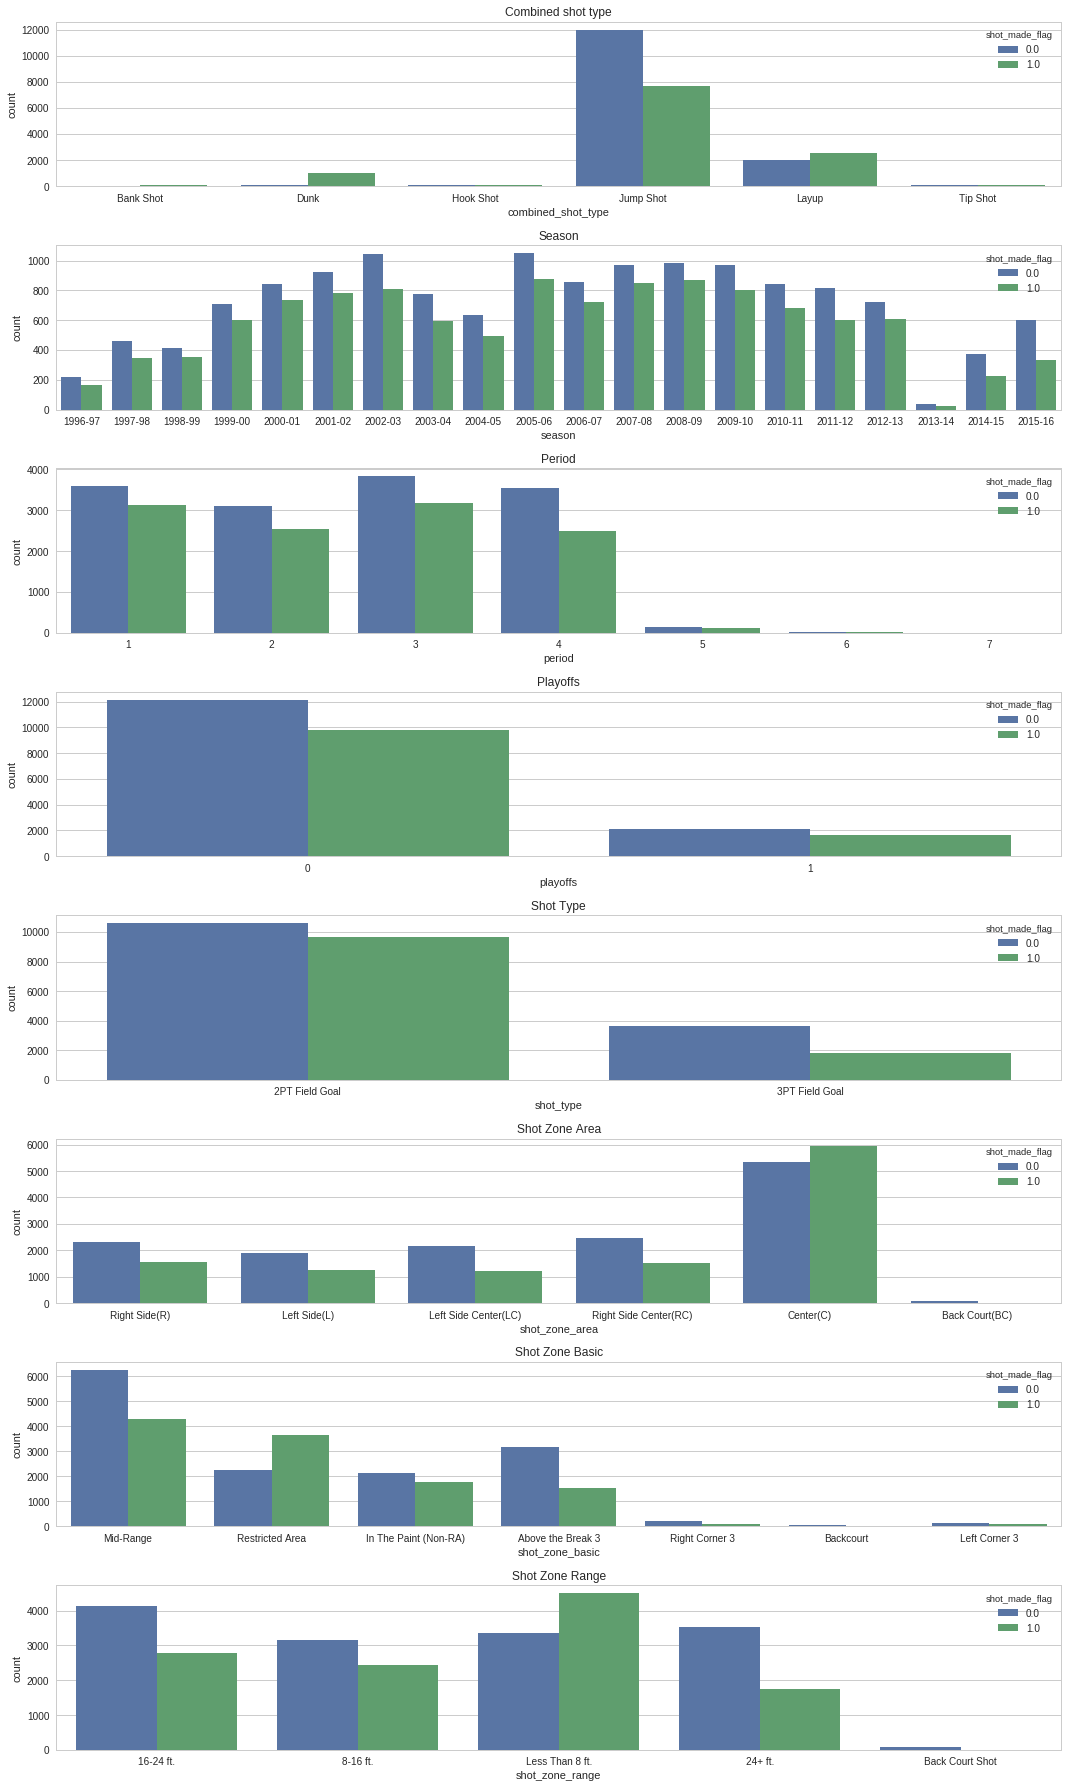

In [11]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

plt.tight_layout()
plt.show()

## 3. Prepare Data

In [12]:
unknown_mask = data['shot_made_flag'].isnull()

### Data Cleaning
We are assuming an independence of each shot - therefore some columns might be dropped

In [13]:
data_cl = data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

There are also many outliers, remove them:

In [14]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

## For now - do not remove anything

### Data Transformation

##### New features

In [15]:
# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

##### Encode categorical variables

In [16]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

Maybe some transformations to Gaussian distribution?

In [17]:
# TODO

## Feature Selection
Let's reduce the number of features

Create views for easier analysis

In [18]:
# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

### Variance Threshold
Find all features with more than 90% variance in values.

In [19]:
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index(['playoffs', 'shot_distance', 'home_play', 'action_type#Jump Shot',
       'combined_shot_type#Jump Shot', 'combined_shot_type#Layup', 'period#1',
       'period#2', 'period#3', 'period#4', 'shot_type#2PT Field Goal',
       'shot_type#3PT Field Goal', 'shot_zone_area#Center(C)',
       'shot_zone_area#Left Side Center(LC)', 'shot_zone_area#Left Side(L)',
       'shot_zone_area#Right Side Center(RC)', 'shot_zone_area#Right Side(R)',
       'shot_zone_basic#Above the Break 3',
       'shot_zone_basic#In The Paint (Non-RA)', 'shot_zone_basic#Mid-Range',
       'shot_zone_basic#Restricted Area', 'shot_zone_range#16-24 ft.',
       'shot_zone_range#24+ ft.', 'shot_zone_range#8-16 ft.',
       'shot_zone_range#Less Than 8 ft.', 'game_month#1', 'game_month#2',
       'game_month#3', 'game_month#4', 'game_month#11', 'game_month#12',
       'loc_x#(-10.96, 8.96]', 'loc_y#(-10.6, 22.8]', 'loc_y#(22.8, 56.2]',
       'loc_y#(123, 156.4]'],
      dtype='object')

### Top 20 most important features
According to `RandomForestClassifier`

In [20]:
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index(['shot_distance', 'action_type#Jump Shot', 'home_play', 'period#3',
       'action_type#Layup Shot', 'period#1', 'period#2', 'period#4',
       'combined_shot_type#Dunk', 'game_month#3', 'game_month#1',
       'game_month#2', 'game_month#4', 'loc_x#(-10.96, 8.96]', 'game_month#12',
       'game_month#11', 'playoffs', 'opponent#SAS', 'opponent#HOU',
       'opponent#DEN'],
      dtype='object')

### Univariate feature selection
Select top 20 features using $chi^2$ test. Features must be positive before applying test.

In [21]:
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['combined_shot_type#Dunk', 'action_type#Jump Shot',
       'shot_zone_basic#Restricted Area', 'loc_x#(-10.96, 8.96]',
       'action_type#Driving Layup Shot', 'shot_zone_range#Less Than 8 ft.',
       'loc_y#(-10.6, 22.8]', 'action_type#Slam Dunk Shot',
       'shot_type#3PT Field Goal', 'action_type#Driving Dunk Shot',
       'shot_zone_area#Center(C)', 'action_type#Running Jump Shot',
       'shot_zone_range#24+ ft.', 'shot_zone_basic#Above the Break 3',
       'combined_shot_type#Layup', 'combined_shot_type#Jump Shot',
       'last_5_sec_in_period', 'action_type#Jump Bank Shot',
       'action_type#Pullup Jump shot',
       'shot_zone_area#Left Side Center(LC)'], dtype=object)

### Recursive Feature Elimination
Select 20 features from using recursive feature elimination (RFE) with logistic regression model.

In [22]:
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, Y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

array(['action_type#Driving Dunk Shot',
       'action_type#Driving Finger Roll Layup Shot',
       'action_type#Driving Finger Roll Shot',
       'action_type#Driving Slam Dunk Shot', 'action_type#Dunk Shot',
       'action_type#Fadeaway Bank shot', 'action_type#Finger Roll Shot',
       'action_type#Hook Shot', 'action_type#Jump Shot',
       'action_type#Layup Shot', 'action_type#Running Bank shot',
       'action_type#Running Hook Shot', 'action_type#Slam Dunk Shot',
       'combined_shot_type#Dunk', 'combined_shot_type#Tip Shot',
       'shot_zone_area#Back Court(BC)', 'shot_zone_range#Back Court Shot',
       'loc_y#(290, 323.4]', 'loc_y#(356.8, 390.2]', 'loc_y#(390.2, 423.6]'], dtype=object)

# Final feature selection
Finally features selected by all methods will be merged together

In [23]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-action_type#Driving Dunk Shot
	-action_type#Driving Finger Roll Layup Shot
	-action_type#Driving Finger Roll Shot
	-action_type#Driving Layup Shot
	-action_type#Driving Slam Dunk Shot
	-action_type#Dunk Shot
	-action_type#Fadeaway Bank shot
	-action_type#Finger Roll Shot
	-action_type#Hook Shot
	-action_type#Jump Bank Shot
	-action_type#Jump Shot
	-action_type#Layup Shot
	-action_type#Pullup Jump shot
	-action_type#Running Bank shot
	-action_type#Running Hook Shot
	-action_type#Running Jump Shot
	-action_type#Slam Dunk Shot
	-combined_shot_type#Dunk
	-combined_shot_type#Jump Shot
	-combined_shot_type#Layup
	-combined_shot_type#Tip Shot
	-game_month#1
	-game_month#11
	-game_month#12
	-game_month#2
	-game_month#3
	-game_month#4
	-home_play
	-last_5_sec_in_period
	-loc_x#(-10.96, 8.96]
	-loc_y#(-10.6, 22.8]
	-loc_y#(123, 156.4]
	-loc_y#(22.8, 56.2]
	-loc_y#(290, 323.4]
	-loc_y#(356.8, 390.2]
	-loc_y#(390.2, 423.6]
	-opponent#DEN
	-opponent#HOU
	-opponent#SAS
	-perio

## Prepare dataset for further analysis

In [24]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]

print('Clean dataset shape: {}'.format(data_cl.shape))
print('Subbmitable dataset shape: {}'.format(data_submit.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(Y.shape))

Clean dataset shape: (30697, 62)
Subbmitable dataset shape: (5000, 62)
Train features shape: (25697, 62)
Target label shape: (25697,)


## PCA Visualization

In [25]:
components = 8
pca = PCA(n_components=components).fit(X)

Show explained variance for each component

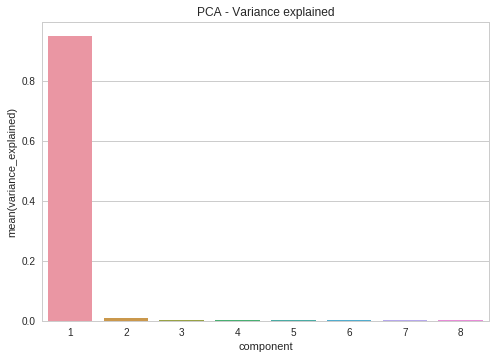

In [26]:
pca_variance_explained_df = pd.DataFrame({
    "component": np.arange(1, components+1),
    "variance_explained": pca.explained_variance_ratio_            
    })

ax = sns.barplot(x='component', y='variance_explained', data=pca_variance_explained_df)
ax.set_title("PCA - Variance explained")
plt.show()

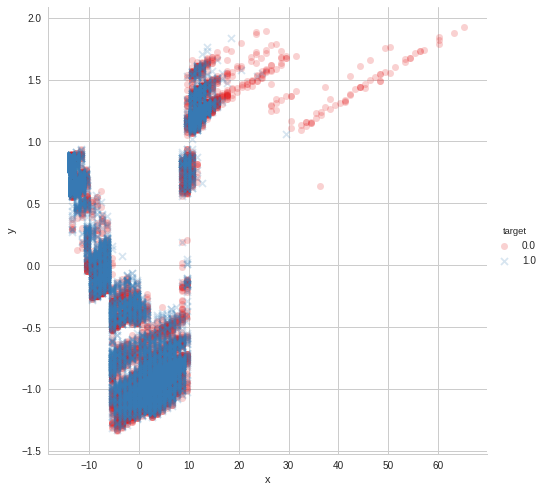

In [27]:
X_pca = pd.DataFrame(pca.transform(X)[:,:2])
X_pca['target'] = Y.values
X_pca.columns = ["x", "y", "target"]

sns.lmplot('x','y', 
           data=X_pca, 
           hue="target", 
           fit_reg=False, 
           markers=["o", "x"], 
           palette="Set1", 
           size=7,
           scatter_kws={"alpha": .2}
          )
plt.show()

## 4. Evaluate Algorithms

In [28]:
seed = 7
processors=1
num_folds=3
num_instances=len(X)
scoring='log_loss'

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)

## Algorithms spot-check

In [29]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVC', SVC(probability=True)))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


LR: (-0.611) +/- (0.003)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


LDA: (-0.613) +/- (0.003)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


K-NN: (-2.171) +/- (0.008)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

CART: (-10.639) +/- (0.367)
NB: (-3.343) +/- (0.291)


By looking at these results is seems that only Logistic Regression and Linear Discriminant Analysis are providing best results and are worth further examination.

But let's look at ...

## Ensembles

### Bagging (Bootstrap Aggregation)
Involves taking multiple samples from the training dataset (with replacement) and training a model for each sample. The final output prediction is averaged across the predictions of all of the sub-models.

#### Bagged Decision Trees
Bagging performs best with algorithms that have high variance (i.e. decision trees without prunning). Let's check their performance

In [30]:
cart = DecisionTreeClassifier()
num_trees = 100

model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(-0.889) +/- (0.026)


#### Random Forest
An extension to bagged decision trees. Samples of the training dataset are taken with replacement, but the trees are constructed in a way that reduces the correlation between individual classifiers. Also the tree size is much slowe due to `max_features`

In [31]:
num_trees = 100
num_features = 10

model = RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(-0.870) +/- (0.044)


#### Extra Trees
In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

In [32]:
num_trees = 100
num_features = 10

model = ExtraTreesClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(-3.749) +/- (0.428)


### Boosting
Boosting ensembles creates a sequence of models that attemtp to correct the mistakes of the models before them in the sequence. Once created, the models make predictions which may be weighted by their demonstrated accuracy and the results are combined to create a final output prediction.

#### AdaBoost

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights $w_1, w_2, ..., w_N$ to each of the training samples. Initially, those weights are all set to $w_i = 1/N$, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence

In [33]:
model = AdaBoostClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(-0.690) +/- (0.000)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


#### Stochastic Gradient Boosting
Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems.

The advantages of GBRT are:

- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

- Scalability, due to the sequential nature of boosting it can hardly be parallelized.

In [34]:
model = GradientBoostingClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(-0.608) +/- (0.004)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


### Hyperparameter tuning
#### Logistic Regression

In [35]:
lr_grid = GridSearchCV(
    estimator = LogisticRegression(random_state=seed),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 1, 10, 100, 1000]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lr_grid.fit(X, Y)

print(lr_grid.best_score_)
print(lr_grid.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

-0.6109324713486984
{'C': 1, 'penalty': 'l2'}


#### Linear Discriminant Analysis

In [36]:
lda_grid = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = {
        'solver': ['lsqr'],
        'shrinkage': [0, 0.25, 0.5, 0.75, 1],
        'n_components': [None, 2, 5, 10]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lda_grid.fit(X, Y)

print(lda_grid.best_score_)
print(lda_grid.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

-0.6131095999315229
{'n_components': None, 'shrinkage': 0, 'solver': 'lsqr'}


### K-NN

In [37]:
knn_grid = GridSearchCV(
    estimator = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    param_grid = {
        'knn__n_neighbors': [25],
        'knn__algorithm': ['ball_tree'],
        'knn__leaf_size': [2, 3, 4],
        'knn__p': [1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

knn_grid.fit(X, Y)

print(knn_grid.best_score_)
print(knn_grid.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

-0.6538339135817597
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 3, 'knn__n_neighbors': 25, 'knn__p': 1}


#### Random Forest

In [38]:
rf_grid = GridSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_features': [18, 20],
        'max_depth': [8, 10],
        'bootstrap': [True]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X, Y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

-0.6071643825310191
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 20, 'n_estimators': 200}


#### AdaBoost

In [39]:
ada_grid = GridSearchCV(
    estimator = AdaBoostClassifier(random_state=seed),
    param_grid = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [10, 25, 50],
        'learning_rate': [1e-3, 1e-2, 1e-1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

ada_grid.fit(X, Y)

print(ada_grid.best_score_)
print(ada_grid.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

-0.6409731408480273
{'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 10}


#### Gradient Boosting

In [40]:
gbm_grid = GridSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [2, 3, 4],
        'max_features': [10, 15, 20],
        'learning_rate': [1e-1, 1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

gbm_grid.fit(X, Y)

print(gbm_grid.best_score_)
print(gbm_grid.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to

-0.6070653736051504
{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 15, 'n_estimators': 100}


### Voting ensemble

In [41]:
# Create sub models
estimators = []

estimators.append(('lr', LogisticRegression(penalty='l2', C=1)))
estimators.append(('gbm', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, max_features=15, warm_start=True, random_state=seed)))
estimators.append(('rf', RandomForestClassifier(bootstrap=True, max_depth=8, n_estimators=200, max_features=20, criterion='entropy', random_state=seed)))
estimators.append(('ada', AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1e-2, n_estimators=10, random_state=seed)))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[2,3,3,1])

results = cross_val_score(ensemble, X, Y, cv=kfold, scoring=scoring,n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:136: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(-0.608) +/- (0.003)


## Make final predictions

In [42]:
model = ensemble

model.fit(X, Y)
preds = model.predict_proba(data_submit)

submission = pd.DataFrame()
submission["shot_id"] = data_submit.index
submission["shot_made_flag"]= preds[:,0]

submission.to_csv("sub.csv",index=False)